In [1]:
import numpy as np, pandas as pd, pickle, matplotlib.pyplot as plt

In [2]:
datadir = '../../../datasets/ppmi/visit_feature_inputs_asof_2019Jan24_using_CMEDTM/'
pd_totals_df = pd.read_csv(datadir + 'PD_totals_across_time.csv')
outcome_path = '../ppmi_survival_models/survival_outcome_subtotals_gdsfixed_using_CMEDTM/set_3.0_0.5_2019Jul08/' \
    + 'cohorts_time_event_dict.pkl'
with open(outcome_path, 'r') as f:
    pd_surv_df = pickle.load(f)['PD']

### Determine a T for censoring approach

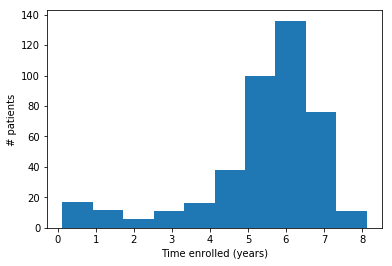

In [3]:
last_visits_df = pd_totals_df.sort_values(by=['EVENT_ID_DUR']).drop_duplicates(subset=['PATNO'], keep='last')
last_visits_df.EVENT_ID_DUR.plot.hist()
plt.xlabel('Time enrolled (years)')
plt.ylabel('# patients')
plt.show()

In [4]:
for i in range(10):
    print('# patients with at least ' + str(i) + ' years enrolled: ' \
          + str(len(last_visits_df.loc[last_visits_df['EVENT_ID_DUR']>=i])))

# patients with at least 0 years enrolled: 423
# patients with at least 1 years enrolled: 406
# patients with at least 2 years enrolled: 394
# patients with at least 3 years enrolled: 382
# patients with at least 4 years enrolled: 361
# patients with at least 5 years enrolled: 323
# patients with at least 6 years enrolled: 223
# patients with at least 7 years enrolled: 87
# patients with at least 8 years enrolled: 11
# patients with at least 9 years enrolled: 0


In [5]:
pd_totals_df.columns

Index([u'PATNO', u'EVENT_ID', u'SCOPA-AUT', u'HVLT_discrim_recog',
       u'HVLT_immed_recall', u'NUPDRS3_untreated', u'QUIP', u'NUPDRS3_on',
       u'EPWORTH', u'STATE_ANXIETY', u'NUPDRS3_off', u'GDSSHORT', u'NUPDRS1',
       u'NUPDRS2', u'HVLT_retent', u'BJLO', u'MOCA', u'LNS', u'TRAIT_ANXIETY',
       u'SEMANTIC_FLUENCY', u'NUPDRS3_maob', u'REMSLEEP', u'NUPDRS4',
       u'INFODT', u'INFODT_DIS_DUR', u'INFODT_TIME_SINCE_ENROLL',
       u'EVENT_ID_DUR', u'DIS_DUR_BY_CONSENTDT'],
      dtype='object')

In [6]:
pd_totals_df['NUPDRS3_any'] = np.where(~pd.isnull(pd_totals_df['NUPDRS3_untreated']), \
                                       pd_totals_df['NUPDRS3_untreated'], \
                                       np.where(~pd.isnull(pd_totals_df['NUPDRS3_off']), \
                                                pd_totals_df['NUPDRS3_off'], \
                                                np.where(~pd.isnull(pd_totals_df['NUPDRS3_on']), \
                                                         pd_totals_df['NUPDRS3_on'], \
                                                         pd_totals_df['NUPDRS3_maob'])))

In [7]:
totals_used = ['SCOPA-AUT', 'HVLT_discrim_recog', 'HVLT_immed_recall', 'NUPDRS3_any', 'QUIP', 'EPWORTH', \
               'STATE_ANXIETY', 'TRAIT_ANXIETY', 'NUPDRS2', 'HVLT_retent', 'BJLO', 'MOCA', 'LNS', 'SEMANTIC_FLUENCY', \
               'REMSLEEP']

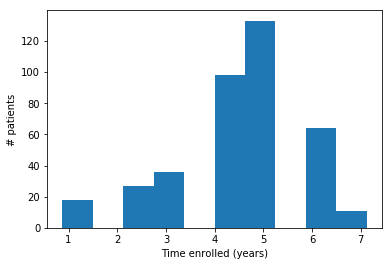

In [8]:
# actually need 2nd to last visit for enroll time due to censoring
pd_totals_df['PATNO_EVENT_ID_DUR'] = pd_totals_df['PATNO'].astype(str) + pd_totals_df['EVENT_ID_DUR'].astype(str)
pd_totals_df_nonan = pd_totals_df.dropna(subset=totals_used)
last_visits_df = pd_totals_df_nonan.sort_values(by=['EVENT_ID_DUR']).drop_duplicates(subset=['PATNO'], keep='last')
second_to_last_visits_df \
    = pd_totals_df_nonan.loc[~pd_totals_df_nonan['PATNO_EVENT_ID_DUR'].isin(last_visits_df['PATNO_EVENT_ID_DUR'])]
second_to_last_visits_df \
    = second_to_last_visits_df.sort_values(by=['EVENT_ID_DUR']).drop_duplicates(subset=['PATNO'], keep='last')
second_to_last_visits_df.EVENT_ID_DUR.plot.hist()
plt.xlabel('Time enrolled (years)')
plt.ylabel('# patients')
plt.show()

In [9]:
for i in range(10):
    print('# patients with at least ' + str(i) + ' years enrolled: ' \
          + str(len(second_to_last_visits_df.loc[second_to_last_visits_df['EVENT_ID_DUR']>=i])))

# patients with at least 0 years enrolled: 387
# patients with at least 1 years enrolled: 386
# patients with at least 2 years enrolled: 369
# patients with at least 3 years enrolled: 342
# patients with at least 4 years enrolled: 306
# patients with at least 5 years enrolled: 208
# patients with at least 6 years enrolled: 75
# patients with at least 7 years enrolled: 11
# patients with at least 8 years enrolled: 0
# patients with at least 9 years enrolled: 0


In [10]:
pd_totals_df.EVENT_ID_DUR.unique()

array([0.125     , 0.        , 0.375     , 0.625     , 0.875     ,
       1.125     , 1.625     , 2.125     , 2.625     , 3.125     ,
       3.625     , 4.125     , 4.625     , 5.125     , 7.125     ,
       6.125     , 0.49556117, 8.125     , 1.58798606, 1.58524816,
       0.75292443, 0.50103698, 1.16361048, 0.33402465, 4.83514377,
       3.08288329, 1.16634838, 0.08213721])

/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


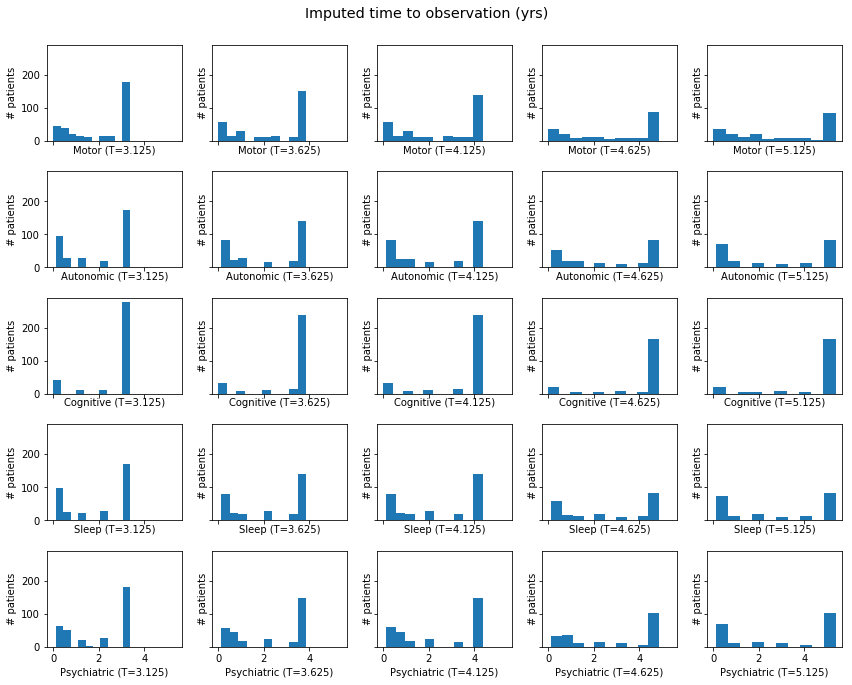

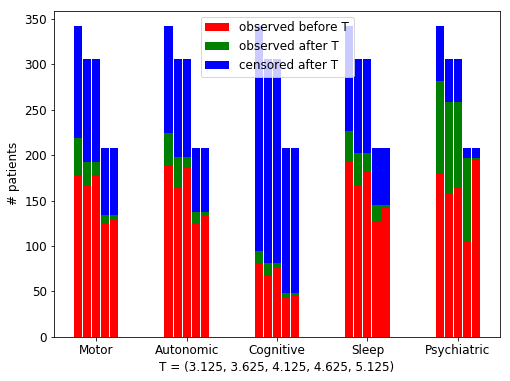

In [9]:
outcomes = ['Motor', 'Autonomic', 'Cognitive', 'Sleep', 'Psychiatric']
ts = [3.125, 3.625, 4.125, 4.625, 5.125]
fig, ax = plt.subplots(nrows=len(outcomes), ncols=len(ts), figsize=(12,10), sharex=True, sharey=True)
plt.rcParams.update({'font.size':12})
obs_before_ts_dict = dict()
obs_after_ts_dict = dict()
cens_after_ts_dict = dict()
for idx in range(len(ts)):
    obs_before_ts_dict[ts[idx]] = []
    obs_after_ts_dict[ts[idx]] = []
    cens_after_ts_dict[ts[idx]] = []
    patnos_enrolled_at_least_i_years \
        = set(second_to_last_visits_df.loc[second_to_last_visits_df['EVENT_ID_DUR']>=ts[idx]].PATNO.values.tolist())
    #print('Require at least ' + str(ts[idx]) + ' years of enrollment: ' \
    #      + str(len(patnos_enrolled_at_least_i_years)) + ' patients')
    pd_surv_df_atleast_i = pd_surv_df.loc[pd_surv_df['PATNO'].isin(patnos_enrolled_at_least_i_years)]
    for outcome_idx in range(len(outcomes)):
        outcome = outcomes[outcome_idx]
        assert len(pd_surv_df_atleast_i.loc[np.logical_and(pd_surv_df_atleast_i[outcome + '_T'] < ts[idx], \
                                                           pd_surv_df_atleast_i[outcome + '_E']==0)])== 0
        pd_surv_df_atleast_i[outcome + '_T_atleast' + str(ts[idx])] \
            = np.where(pd_surv_df_atleast_i[outcome + '_E']==0, ts[idx] + 0.25, \
                       pd_surv_df_atleast_i[outcome + '_T']) # set censored to max time
        pd_surv_df_atleast_i[outcome + '_T_atleast' + str(ts[idx])] \
            = np.where(pd_surv_df_atleast_i[outcome + '_T_atleast' + str(ts[idx])] >= ts[idx] + 0.25, ts[idx] + 0.25, \
                       pd_surv_df_atleast_i[outcome + '_T_atleast' + str(ts[idx])]) # set larger observed to max time
        ax[outcome_idx, idx].hist(pd_surv_df_atleast_i[outcome + '_T_atleast' + str(ts[idx])])
        ax[outcome_idx, idx].set_xlabel(outcome + ' (T=' + str(ts[idx]) + ')')
        ax[outcome_idx, idx].set_ylabel('# patients')
        #print(outcome + ': ' + str(pd_surv_df_atleast_i[outcome + '_E'].sum()) + ' observed, ' \
        #      + str(len(pd_surv_df_atleast_i) - pd_surv_df_atleast_i[outcome + '_E'].sum()) + ' censored')
        num_obs_before_t \
            = len(pd_surv_df_atleast_i.loc[np.logical_and(pd_surv_df_atleast_i[outcome + '_E']==1, \
                                                          pd_surv_df_atleast_i[outcome + '_T'] <= ts[idx] + 0.25)])
        obs_before_ts_dict[ts[idx]].append(num_obs_before_t)
        num_obs_after_t \
            = len(pd_surv_df_atleast_i.loc[np.logical_and(pd_surv_df_atleast_i[outcome + '_E']==1, \
                                                          pd_surv_df_atleast_i[outcome + '_T'] > ts[idx] + 0.25)])
        obs_after_ts_dict[ts[idx]].append(num_obs_after_t)
        num_cens_after_t = len(pd_surv_df_atleast_i.loc[pd_surv_df_atleast_i[outcome + '_E']==0])
        cens_after_ts_dict[ts[idx]].append(num_cens_after_t)
plt.suptitle('Imputed time to observation (yrs)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('impute_obs_time_distribs.pdf')
plt.show()
if len(ts) == 3:
    x_offsets = [-0.1, 0.0, 0.1]
elif len(ts) == 4:
    x_offsets = [-0.15, -0.05, 0.05, 0.15]
elif len(ts) == 5:
    x_offsets = [-0.2, -0.1, 0, 0.1, 0.2]
fig, ax = plt.subplots(figsize=(8,6))
for idx in range(len(ts)):
    if idx == 0:
        labels = ['observed before T', 'observed after T', 'censored after T']
    else:
        labels = [None, None, None]
    ax.bar(np.arange(len(outcomes))+x_offsets[idx], obs_before_ts_dict[ts[idx]], align='center', width=0.09, \
           label=labels[0], color='red')
    ax.bar(np.arange(len(outcomes))+x_offsets[idx], obs_after_ts_dict[ts[idx]], align='center', width=0.09, \
           bottom=obs_before_ts_dict[ts[idx]], label=labels[1], color='green')
    ax.bar(np.arange(len(outcomes))+x_offsets[idx], cens_after_ts_dict[ts[idx]], align='center', width=0.09, \
           bottom=np.array(obs_before_ts_dict[ts[idx]]) + np.array(obs_after_ts_dict[ts[idx]]), \
           label=labels[2], color='blue')
ax.set_xticklabels([''] + outcomes)
ts_str = 'T = ('
for t in ts:
    ts_str += str(t) + ', '
ts_str = ts_str[:-2] + ')'
ax.set_xlabel(ts_str)
ax.set_ylabel('# patients')
plt.legend()
plt.savefig('obs_cens_around_T.pdf')
plt.show()

Setting T = 4.125 seems to be the best trade-off between sample size and cutting off too many observations. Psychiatric would be the only outcome that has a lot of observations after the cutoff.

### Visualize outcomes in pairwise plots and t-SNE

In [12]:
from seaborn import heatmap
from sklearn.manifold import TSNE

In [13]:
outcomes = ['Motor', 'Autonomic', 'Cognitive', 'Sleep', 'Psychiatric']
patnos_enrolled_at_least_i_years \
    = set(second_to_last_visits_df.loc[second_to_last_visits_df['EVENT_ID_DUR']>=4.125].PATNO.values.tolist())
pd_surv_df_atleast_i = pd_surv_df.loc[pd_surv_df['PATNO'].isin(patnos_enrolled_at_least_i_years)]
outcome_T_atleast_i_cols = []
for outcome in outcomes:
    pd_surv_df_atleast_i[outcome + '_T_atleast' + str(4.125)] \
        = np.where(pd_surv_df_atleast_i[outcome + '_E']==0, 4.125 + 0.5, \
                   pd_surv_df_atleast_i[outcome + '_T']) # set censored to max time
    pd_surv_df_atleast_i[outcome + '_T_atleast' + str(4.125)] \
        = np.where(pd_surv_df_atleast_i[outcome + '_T_atleast' + str(4.125)] >= 4.125 + 0.5, 4.125 + 0.5, \
                   pd_surv_df_atleast_i[outcome + '_T_atleast' + str(4.125)]) # set larger observed to max time
    outcome_T_atleast_i_cols.append(outcome + '_T_atleast' + str(4.125))

/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [14]:
pd_surv_df_atleast_i.head()

,PATNO,SCOPA-AUT_T,SCOPA-AUT_E,Autonomic_T,Autonomic_E,EPWORTH_T,EPWORTH_E,REMSLEEP_T,REMSLEEP_E,Sleep_T,...,Motor_E,hybrid_T,hybrid_E,hybrid_requiremotor_E,hybrid_requiremotor_T,Motor_T_atleast4.125,Autonomic_T_atleast4.125,Cognitive_T_atleast4.125,Sleep_T_atleast4.125,Psychiatric_T_atleast4.125
0,3001,0.125,1,0.125,1,7.125,0,2.125,1,2.125,...,1,5.125,1,1,5.125,4.625,0.125,4.625,2.125,4.625
1,3002,0.125,1,0.125,1,0.125,1,0.125,1,0.125,...,1,0.125,1,1,0.375,0.375,0.125,4.625,0.125,0.125
2,3003,0.125,1,0.125,1,5.125,0,6.125,0,5.125,...,1,5.125,1,1,5.125,0.125,0.125,4.625,4.625,4.625
5,3010,2.125,1,2.125,1,5.125,0,0.125,1,0.125,...,1,0.625,1,1,0.625,0.625,2.125,4.625,0.125,0.625
8,3018,0.625,1,0.625,1,0.125,1,6.125,0,0.125,...,1,0.625,1,1,0.875,0.875,0.625,4.625,0.125,0.125


In [15]:
outcome_T_atleast_i = [outcome + '_T_atleast4.125' for outcome in outcomes]
tsne_2comp_data = TSNE().fit_transform(pd_surv_df_atleast_i[outcome_T_atleast_i].values)

In [16]:
tsne_1comp_data = TSNE(n_components=1).fit_transform(pd_surv_df_atleast_i[outcome_T_atleast_i].values)

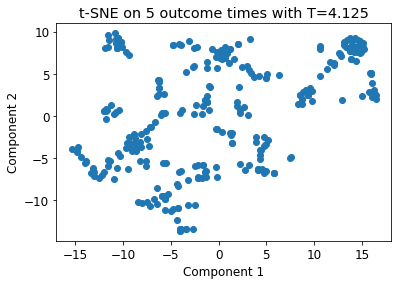

In [17]:
plt.scatter(tsne_2comp_data[:,0], tsne_2comp_data[:,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE on 5 outcome times with T=4.125')
plt.show()

In [18]:
common_ts = [0., 0.125, 0.375, 0.625, 0.875, 1.125, 1.625, 2.125, 2.625, 3.125, 3.625, 4.125, 4.625]

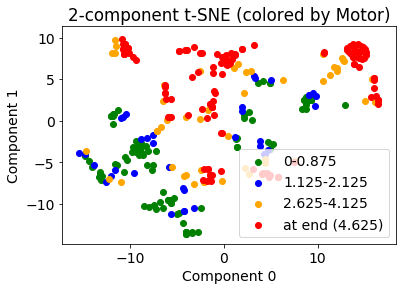

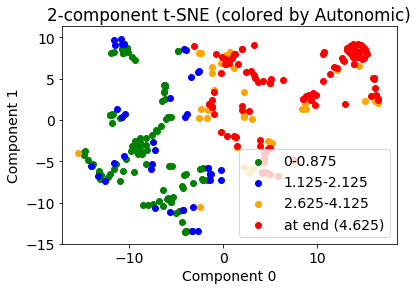

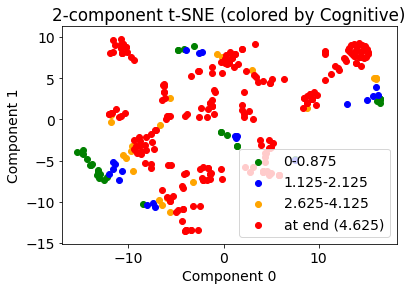

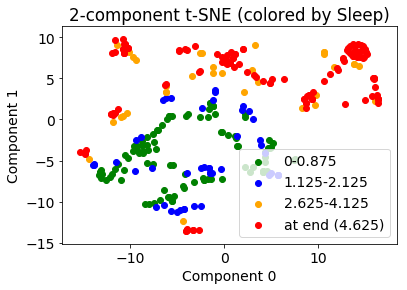

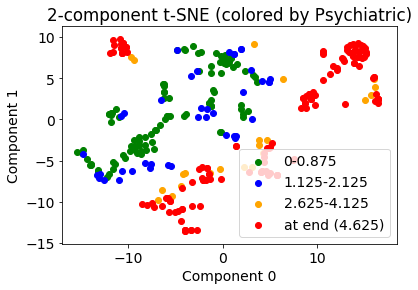

In [31]:
plt.rcParams.update({'font.size': 14})
for outcome in outcomes:
    T_early_idx = np.nonzero(np.where(pd_surv_df_atleast_i[outcome + '_T_atleast4.125']<1, 1, 0))[0]
    T_middle_idx = np.nonzero(np.where(np.logical_and(pd_surv_df_atleast_i[outcome + '_T_atleast4.125']>=1, \
                                                      pd_surv_df_atleast_i[outcome + '_T_atleast4.125']<2.5), \
                                       1, 0))[0]
    T_late_idx = np.nonzero(np.where(np.logical_and(pd_surv_df_atleast_i[outcome + '_T_atleast4.125']>=2.5, \
                                                    pd_surv_df_atleast_i[outcome + '_T_atleast4.125']<4.5), 1, 0))[0]
    T_at_end_idx = np.nonzero(np.where(pd_surv_df_atleast_i[outcome + '_T_atleast4.125']==4.625, 1, 0))[0]
    assert len(T_early_idx) + len(T_middle_idx) + len(T_late_idx) + len(T_at_end_idx) == len(pd_surv_df_atleast_i)
    plt.scatter(tsne_2comp_data[T_early_idx,0], tsne_2comp_data[T_early_idx,1], color='green', label='0-0.875')
    plt.scatter(tsne_2comp_data[T_middle_idx,0], tsne_2comp_data[T_middle_idx,1], color='blue', label='1.125-2.125')
    plt.scatter(tsne_2comp_data[T_late_idx,0], tsne_2comp_data[T_late_idx,1], color='orange', label='2.625-4.125')
    plt.scatter(tsne_2comp_data[T_at_end_idx,0], tsne_2comp_data[T_at_end_idx,1], color='red', \
                label='at end (4.625)')
    plt.legend()
    plt.xlabel('Component 0')
    plt.ylabel('Component 1')
    plt.title('2-component t-SNE (colored by ' + outcome + ')')
    plt.savefig('tSNE_2comp_' + outcome + '.pdf')
    plt.show()

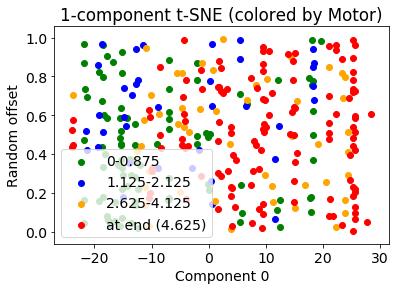

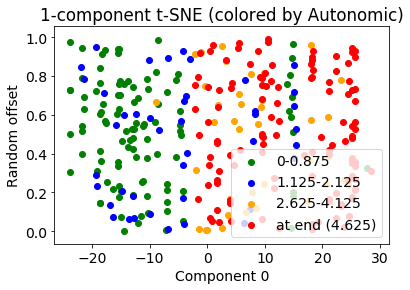

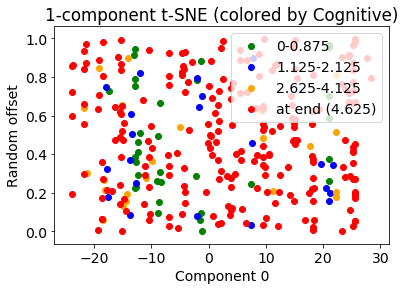

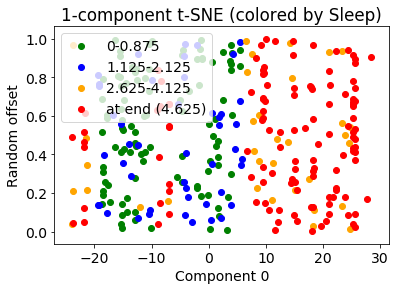

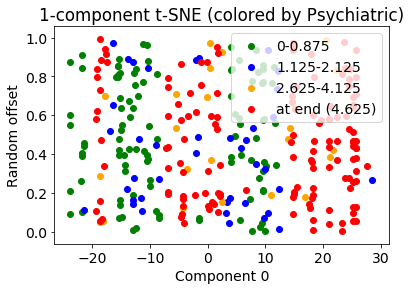

In [32]:
plt.rcParams.update({'font.size': 14})
for outcome in outcomes:
    T_early_idx = np.nonzero(np.where(pd_surv_df_atleast_i[outcome + '_T_atleast4.125']<1, 1, 0))[0]
    T_middle_idx = np.nonzero(np.where(np.logical_and(pd_surv_df_atleast_i[outcome + '_T_atleast4.125']>=1, \
                                                      pd_surv_df_atleast_i[outcome + '_T_atleast4.125']<2.5), \
                                       1, 0))[0]
    T_late_idx = np.nonzero(np.where(np.logical_and(pd_surv_df_atleast_i[outcome + '_T_atleast4.125']>=2.5, \
                                                    pd_surv_df_atleast_i[outcome + '_T_atleast4.125']<4.5), 1, 0))[0]
    T_at_end_idx = np.nonzero(np.where(pd_surv_df_atleast_i[outcome + '_T_atleast4.125']==4.625, 1, 0))[0]
    assert len(T_early_idx) + len(T_middle_idx) + len(T_late_idx) + len(T_at_end_idx) == len(pd_surv_df_atleast_i)
    plt.scatter(tsne_1comp_data[T_early_idx,0], np.random.sample(size=len(T_early_idx)), color='green', \
                label='0-0.875')
    plt.scatter(tsne_1comp_data[T_middle_idx,0], np.random.sample(size=len(T_middle_idx)), color='blue', \
                label='1.125-2.125')
    plt.scatter(tsne_1comp_data[T_late_idx,0], np.random.sample(size=len(T_late_idx)), color='orange', \
                label='2.625-4.125')
    plt.scatter(tsne_1comp_data[T_at_end_idx,0], np.random.sample(size=len(T_at_end_idx)), color='red', \
                label='at end (4.625)')
    plt.legend()
    plt.xlabel('Component 0')
    plt.ylabel('Random offset')
    plt.title('1-component t-SNE (colored by ' + outcome + ')')
    plt.savefig('tSNE_1comp_' + outcome + '.pdf')
    plt.show()

In [21]:
pd_totals_df.EVENT_ID_DUR.value_counts()

0.125000    423
0.000000    423
0.375000    409
1.125000    395
0.625000    390
1.625000    382
2.125000    378
2.625000    370
3.125000    366
3.625000    353
0.875000    349
4.125000    347
4.625000    318
5.125000    316
6.125000    217
7.125000     87
8.125000     11
1.587986      3
1.163610      1
0.752924      1
1.585248      1
0.501037      1
4.835144      1
1.166348      1
0.334025      1
0.495561      1
3.082883      1
0.082137      1
Name: EVENT_ID_DUR, dtype: int64

In [22]:
common_ts = [0., 0.125, 0.375, 0.625, 0.875, 1.125, 1.625, 2.125, 2.625, 3.125, 3.625, 4.125, 4.625]

In [23]:
def make_pairwise_plot(outcome_i, outcome_j):
    pairwise_distribs = np.zeros((len(common_ts), len(common_ts)))
    for t_i in range(pairwise_distribs.shape[0]):
        for t_j in range(pairwise_distribs.shape[1]):
            pairwise_distribs[t_i, t_j] \
                = len(pd_surv_df_atleast_i.loc[np.logical_and(pd_surv_df_atleast_i[outcome_i + '_T_atleast4.125']==common_ts[t_i], \
                                                              pd_surv_df_atleast_i[outcome_j + '_T_atleast4.125']==common_ts[t_j])])
    pairwise_distribs_df = pd.DataFrame({outcome_i + '_T': common_ts})
    for t_j in range(pairwise_distribs.shape[1]):
        pairwise_distribs_df[common_ts[t_j]] = pairwise_distribs[:,t_j]
    pairwise_distribs_df = pairwise_distribs_df.set_index(outcome_i + '_T')
    fig, ax = plt.subplots(figsize=(10,8))
    ax = heatmap(pairwise_distribs_df, vmin=0, vmax=100, annot=True, ax=ax)
    ax.set_xlabel(outcome_j)
    ax.set_ylabel(outcome_i)
    plt.show()
             

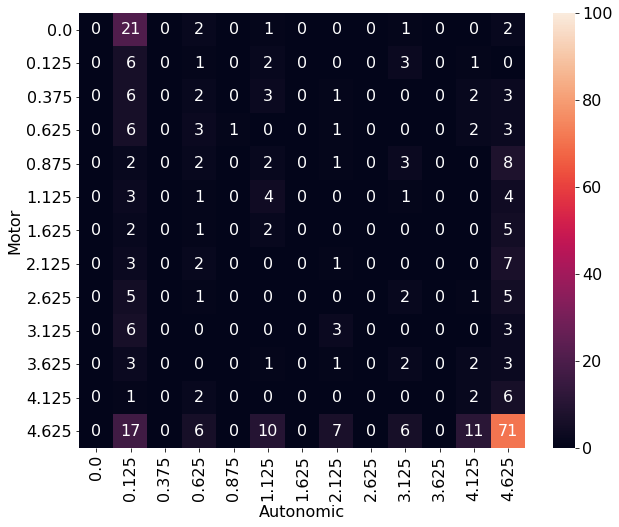

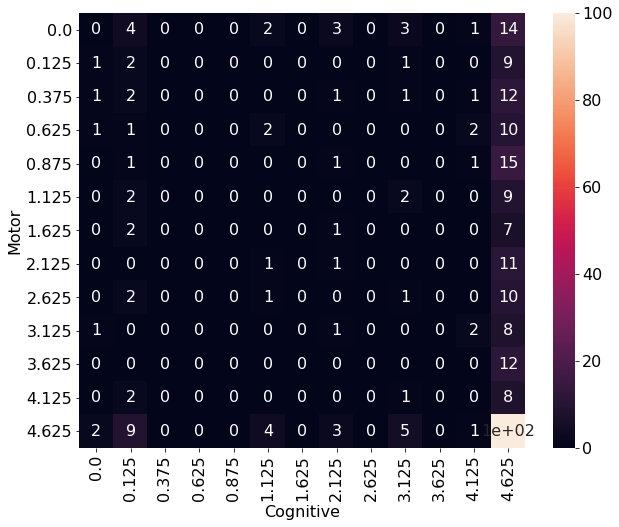

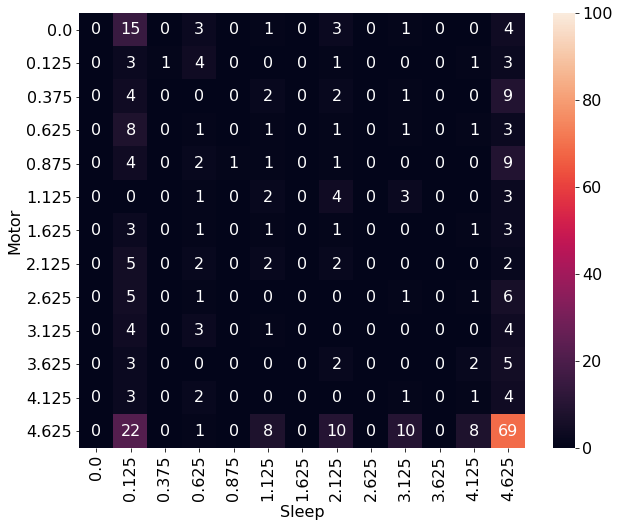

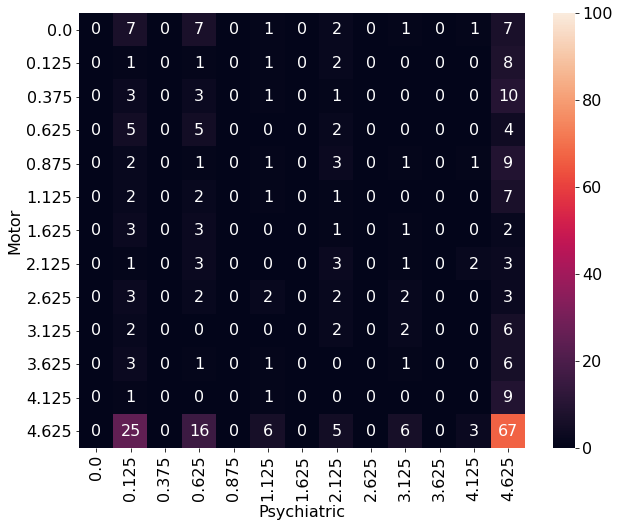

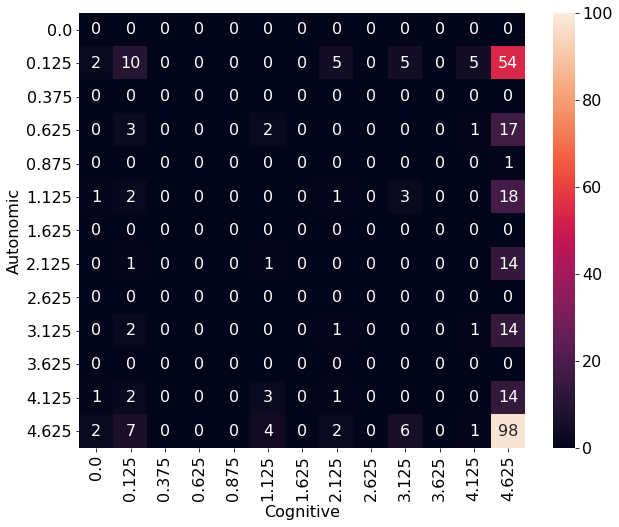

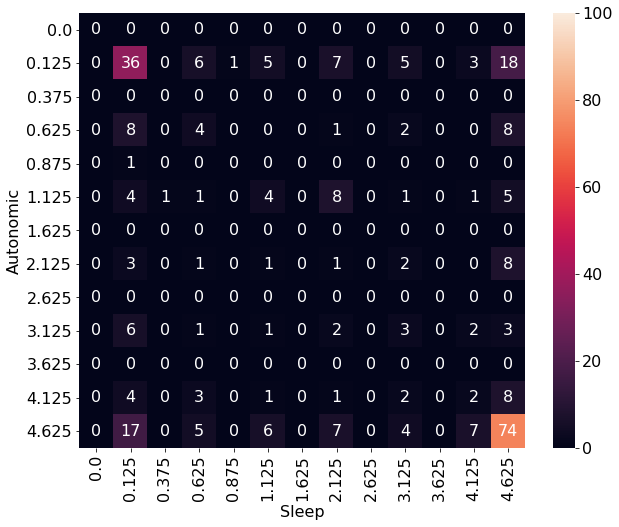

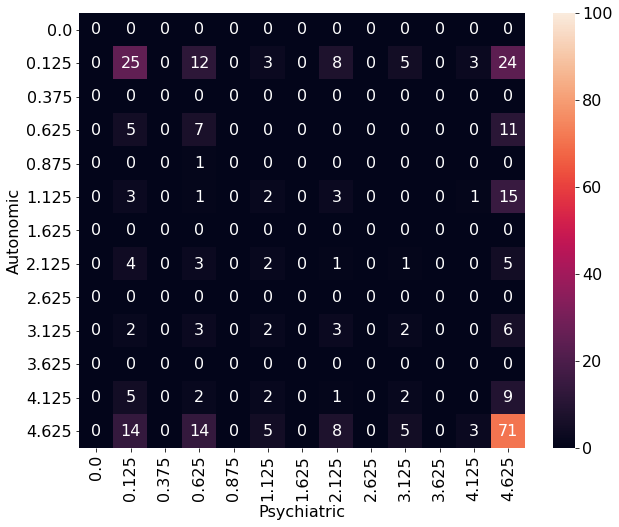

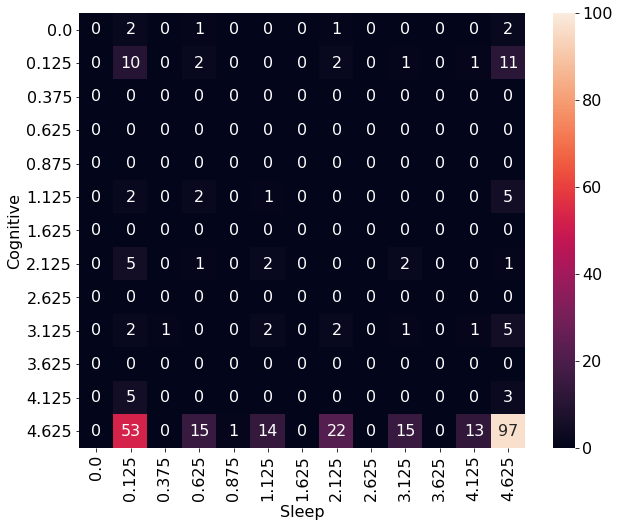

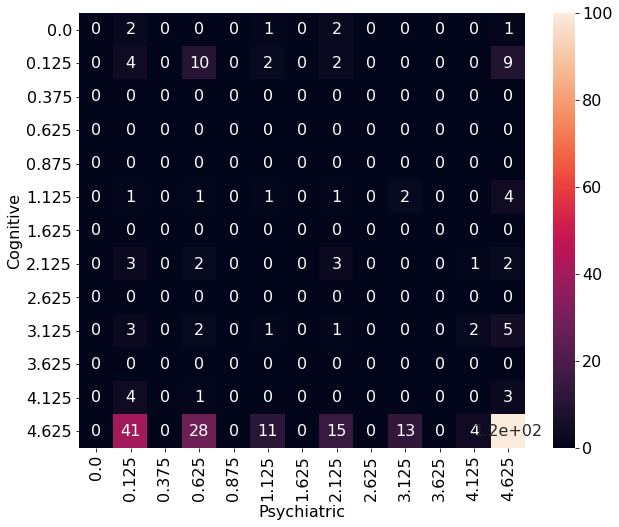

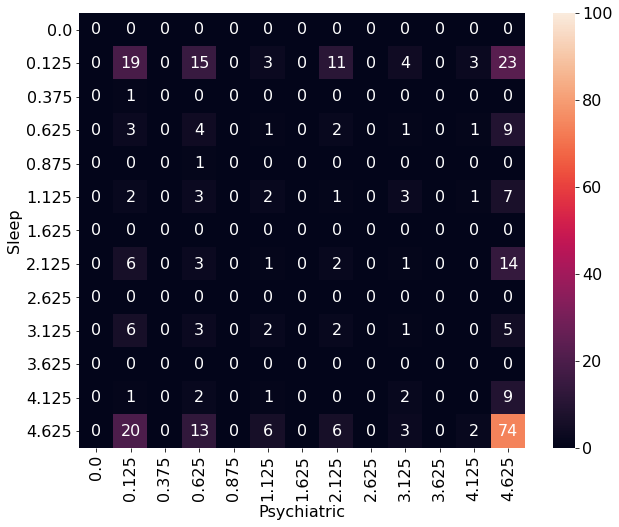

In [24]:
for i in range(len(outcomes)-1):
    for j in range(i+1, len(outcomes)):
        make_pairwise_plot(outcomes[i], outcomes[j])

### Plot inertia against number of clusters in kmeans
Inertia is the sum of squared distances from each sample to cluster center

In [10]:
patnos_enrolled_at_least_i_years \
    = set(second_to_last_visits_df.loc[second_to_last_visits_df['EVENT_ID_DUR']>=4.125].PATNO.values.tolist())
pd_surv_df_atleast_i = pd_surv_df.loc[pd_surv_df['PATNO'].isin(patnos_enrolled_at_least_i_years)]
outcome_T_atleast_i_cols = []
for outcome in outcomes:
    pd_surv_df_atleast_i[outcome + '_T_atleast' + str(4.125)] \
        = np.where(pd_surv_df_atleast_i[outcome + '_E']==0, 4.125 + 0.5, \
                   pd_surv_df_atleast_i[outcome + '_T']) # set censored to max time
    pd_surv_df_atleast_i[outcome + '_T_atleast' + str(4.125)] \
        = np.where(pd_surv_df_atleast_i[outcome + '_T_atleast' + str(4.125)] >= 4.125 + 0.5, 4.125 + 0.5, \
                   pd_surv_df_atleast_i[outcome + '_T_atleast' + str(4.125)]) # set larger observed to max time
    outcome_T_atleast_i_cols.append(outcome + '_T_atleast' + str(4.125))

/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
all_patnos = pd_surv_df_atleast_i.PATNO.values
np.random.shuffle(all_patnos)
train_test_cutoff = int(.85*len(all_patnos))
train_patnos = set(all_patnos[:train_test_cutoff].tolist())
test_patnos = set(all_patnos[train_test_cutoff:].tolist())
train_df = pd_surv_df_atleast_i.loc[pd_surv_df_atleast_i['PATNO'].isin(train_patnos)]
test_df = pd_surv_df_atleast_i.loc[pd_surv_df_atleast_i['PATNO'].isin(test_patnos)]

In [12]:
from sklearn.cluster import KMeans

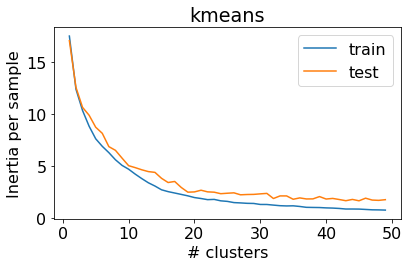

In [13]:
train_inertias = []
test_inertias = []
max_n_clust = 50
plt.rcParams.update({'font.size': 16})
for n_clust in range(1,max_n_clust):
    kmeans = KMeans(n_clusters=n_clust, random_state=7)
    kmeans.fit(train_df[outcome_T_atleast_i_cols])
    train_inertias.append(kmeans.inertia_/len(train_df))
    test_inertias.append(-1*kmeans.score(test_df[outcome_T_atleast_i_cols])/len(test_df))
plt.plot(range(1,max_n_clust), train_inertias, label='train')
plt.plot(range(1,max_n_clust), test_inertias, label='test')
plt.legend()
plt.xlabel('# clusters')
plt.ylabel('Inertia per sample')
plt.title('kmeans')
plt.tight_layout()
plt.savefig('kmeans_inertia_v_num_clust.pdf')
plt.show()

In [29]:
len(train_df)

260

In [30]:
len(test_df)

46